In [1]:
!pip install nltk
!pip install torchtext

mxnet 1.3.0.post0 has requirement numpy<1.15.0,>=1.8.2, but you'll have numpy 1.15.2 which is incompatible.
kmeans-smote 0.1.0 has requirement imbalanced-learn<0.4,>=0.3.1, but you'll have imbalanced-learn 0.5.0.dev0 which is incompatible.
kmeans-smote 0.1.0 has requirement numpy<1.15,>=1.13, but you'll have numpy 1.15.2 which is incompatible.
fastai 0.7.0 has requirement torch<0.4, but you'll have torch 0.4.1.post2 which is incompatible.
anaconda-client 1.7.2 has requirement python-dateutil>=2.6.1, but you'll have python-dateutil 2.6.0 which is incompatible.
imbalanced-learn 0.5.0.dev0 has requirement scikit-learn>=0.20, but you'll have scikit-learn 0.19.1 which is incompatible.
mxnet 1.3.0.post0 has requirement numpy<1.15.0,>=1.8.2, but you'll have numpy 1.15.2 which is incompatible.
kmeans-smote 0.1.0 has requirement imbalanced-learn<0.4,>=0.3.1, but you'll have imbalanced-learn 0.5.0.dev0 which is incompatible.
kmeans-smote 0.1.0 has requirement numpy<1.15,>=1.13, but you'll have n

# <a name="content_list">Home work III</a>
   1. [Preprocessing of text data](#preprocessing)
       1. [Loading data](#loading_data)
       2. [Loading embeddings](#loading_embeddings)
       3. [Vocabulary](#vocabulary)
           1. [Contractions](#contractions)
           2. [Special characters](#special_characters)
           3. [Spelling mistakes](#spelling_mistakes)
   2. [Simple feed-forward neural network model](#simplenn)
   3. [TF-IDF  vectorizer and Logistic regression](#logit)
   4. [Summary](#summary)

Course: Introduction in machine learning

Lecturer: Taras Lehinevych

Author: Kyryll Vasylenko

# <a name="preprocessing">Preprocessing of text data</a>

As information for data preprocessing I used Deiters kernel "How to: Preprocessing when using embeddings"

I for data preprocessing I used Glove, Paragram, FastText embeddings because they are the most popular in examples for model training

[Back to content list](#content_list)

In [2]:
import pandas as pd
import numpy as np
import operator 
import re

## <a name="loading_data">Loading data</a>

[Back to content list](#content_list)

In [3]:
train = pd.read_csv("../input/train.csv").drop('target', axis=1)
test = pd.read_csv("../input/test.csv")
df = pd.concat([train ,test])

print("Number of texts: ", df.shape[0])

Number of texts:  1362492


## <a name="loading_embeddings">Loading embeddings</a>

[Back to content list](#content_list)

In [4]:
def load_embed(file):
    """Load embedding from file
    """
    def get_coefs(word,*arr): 
        return word, np.asarray(arr, dtype='float32')
    
    if file == '../input/embeddings/wiki-news-300d-1M/wiki-news-300d-1M.vec':
        embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(file) if len(o)>100)
    else:
        embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(file, encoding='latin'))
        
    return embeddings_index

In [5]:
glove = '../input/embeddings/glove.840B.300d/glove.840B.300d.txt'
paragram =  '../input/embeddings/paragram_300_sl999/paragram_300_sl999.txt'
wiki_news = '../input/embeddings/wiki-news-300d-1M/wiki-news-300d-1M.vec'

In [6]:
print("Extracting GloVe embedding")
embed_glove = load_embed(glove)
print("Extracting Paragram embedding")
embed_paragram = load_embed(paragram)
print("Extracting FastText embedding")
embed_fasttext = load_embed(wiki_news)

Extracting GloVe embedding
Extracting Paragram embedding
Extracting FastText embedding


## <a name="vocabulary">Vocabulary</a>

[Back to content list](#content_list)

In [7]:
def build_vocab(texts):
    """Build vocabulary with word as key and this words count as value
    """
    sentences = texts.apply(lambda x: x.split()).values
    vocab = {}
    for sentence in sentences:
        for word in sentence:
            try:
                vocab[word] += 1
            except KeyError:
                vocab[word] = 1
    return vocab

In [8]:
def check_coverage(vocab, embeddings_index):
    """Check coverage of vocabulary in embedding
    """
    known_words = {}
    unknown_words = {}
    nb_known_words = 0
    nb_unknown_words = 0
    for word in vocab.keys():
        try:
            known_words[word] = embeddings_index[word]
            nb_known_words += vocab[word]
        except:
            unknown_words[word] = vocab[word]
            nb_unknown_words += vocab[word]
            pass

    print('Found embeddings for {:.2%} of vocab'.format(len(known_words) / len(vocab)))
    print('Found embeddings for  {:.2%} of all text'.format(nb_known_words / (nb_known_words + nb_unknown_words)))
    unknown_words = sorted(unknown_words.items(), key=operator.itemgetter(1))[::-1]

    return unknown_words

In [9]:
vocab = build_vocab(df['question_text'])

In [10]:
print("Glove : ")
oov_glove = check_coverage(vocab, embed_glove)
print("Paragram : ")
oov_paragram = check_coverage(vocab, embed_paragram)
print("FastText : ")
oov_fasttext = check_coverage(vocab, embed_fasttext)

Glove : 
Found embeddings for 32.77% of vocab
Found embeddings for  88.15% of all text
Paragram : 
Found embeddings for 19.37% of vocab
Found embeddings for  72.21% of all text
FastText : 
Found embeddings for 29.77% of vocab
Found embeddings for  87.66% of all text


In [11]:
# Paragam seems to have a significantly lower coverage. Lets check why
oov_paragram

[('What', 436013),
 ('I', 319441),
 ('How', 273144),
 ('Why', 148582),
 ('Is', 113627),
 ('Can', 54992),
 ('Which', 49357),
 ('Do', 41756),
 ('If', 35896),
 ('Are', 30442),
 ('Does', 24142),
 ('Who', 22884),
 ('Where', 20008),
 ('Should', 17269),
 ('India?', 17082),
 ('Will', 15283),
 ('When', 15084),
 ('India', 14270),
 ('Indian', 13441),
 ('it?', 13436),
 ("I'm", 13344),
 ("What's", 12985),
 ('Trump', 10569),
 ('Quora', 10447),
 ('In', 10441),
 ('Would', 10307),
 ('US', 9832),
 ('do?', 9112),
 ('My', 8463),
 ('The', 8215),
 ('life?', 8074),
 ('Did', 7891),
 ('Have', 7519),
 ('American', 6965),
 ('you?', 6553),
 ('me?', 6485),
 ('them?', 6421),
 ('Has', 6092),
 ('time?', 5994),
 ('world?', 5632),
 ('Chinese', 5629),
 ('English', 5594),
 ('people?', 5191),
 ('why?', 5144),
 ('Quora?', 4872),
 ('As', 4814),
 ('Could', 4697),
 ('Google', 4679),
 ('like?', 4677),
 ('China', 4648),
 ('for?', 4631),
 ('A', 4621),
 ('United', 4600),
 ('Americans', 4557),
 ('Was', 4534),
 ('JEE', 4431),
 ('wo

It does not understand upper letters, let us lower our texts

In [12]:
df['lowered_question'] = df['question_text'].apply(lambda x: x.lower())
vocab_low = build_vocab(df['lowered_question'])

In [13]:
print("Glove : ")
oov_glove = check_coverage(vocab_low, embed_glove)
print("Paragram : ")
oov_paragram = check_coverage(vocab_low, embed_paragram)
print("FastText : ")
oov_fasttext = check_coverage(vocab_low, embed_fasttext)

Glove : 
Found embeddings for 27.10% of vocab
Found embeddings for  87.88% of all text
Paragram : 
Found embeddings for 31.01% of vocab
Found embeddings for  88.21% of all text
FastText : 
Found embeddings for 21.74% of vocab
Found embeddings for  87.14% of all text


Good, but we lost a bit of information on the other embeddings.

We have some words that are known with upper letters and uknown without.

We will add lower word in embedding if it doesn't have an embedding.

In [14]:
def add_lower(embedding, vocab):
    """Add lower vocab words in embedding
    """
    count = 0
    for word in vocab:
        if word in embedding and word.lower() not in embedding:  
            embedding[word.lower()] = embedding[word]
            count += 1
    print(f"Added {count} words to embedding")

In [15]:
print("Glove : ")
add_lower(embed_glove, vocab)
print("Paragram : ")
add_lower(embed_paragram, vocab)
print("FastText : ")
add_lower(embed_fasttext, vocab)

Glove : 
Added 15199 words to embedding
Paragram : 
Added 0 words to embedding
FastText : 
Added 27908 words to embedding


In [16]:
print("Glove : ")
oov_glove = check_coverage(vocab_low, embed_glove)
print("Paragram : ")
oov_paragram = check_coverage(vocab_low, embed_paragram)
print("FastText : ")
oov_fasttext = check_coverage(vocab_low, embed_fasttext)

Glove : 
Found embeddings for 30.39% of vocab
Found embeddings for  88.19% of all text
Paragram : 
Found embeddings for 31.01% of vocab
Found embeddings for  88.21% of all text
FastText : 
Found embeddings for 27.77% of vocab
Found embeddings for  87.73% of all text


In [17]:
# Lets check out of vocabulary words
oov_glove[:10]

[('india?', 17092),
 ("what's", 13977),
 ('it?', 13702),
 ('do?', 9125),
 ('life?', 8114),
 ('why?', 7674),
 ('you?', 6572),
 ('me?', 6525),
 ('them?', 6423),
 ('time?', 6021)]

Problems:
- contractions
- punctuation

### <a name="contractions">Contractions</a>

[Back to content list](#content_list)

In [18]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have" }

In [19]:
def known_contractions(embed):
    """Checks contractions in embedding
    """
    known = []
    for contract in contraction_mapping:
        if contract in embed:
            known.append(contract)
    return known

In [20]:
print("Contractions in embeddings:")
print("   Glove :")
print(known_contractions(embed_glove))
print("   Paragram :")
print(known_contractions(embed_paragram))
print("   FastText :")
print(known_contractions(embed_fasttext))

Contractions in embeddings:
   Glove :
["can't", "'cause", "didn't", "doesn't", "don't", "I'd", "I'll", "I'm", "I've", "i'd", "i'll", "i'm", "i've", "it's", "ma'am", "o'clock", "that's", "you'll", "you're"]
   Paragram :
["can't", "'cause", "didn't", "doesn't", "don't", "i'd", "i'll", "i'm", "i've", "it's", "ma'am", "o'clock", "that's", "you'll", "you're"]
   FastText :
[]


In [21]:
def clean_contractions(text, mapping):
    """Remove contractions from text
    """
    specials = ["’", "‘", "´", "`"]
    for s in specials:
        text = text.replace(s, "'")
    text = ' '.join([mapping[t] if t in mapping else t for t in text.split(" ")])
    return text

In [22]:
df['treated_question'] = df['lowered_question'].apply(lambda x: clean_contractions(x, contraction_mapping))

In [23]:
vocab = build_vocab(df['treated_question'])
print("Glove : ")
oov_glove = check_coverage(vocab, embed_glove)
print("Paragram : ")
oov_paragram = check_coverage(vocab, embed_paragram)
print("FastText : ")
oov_fasttext = check_coverage(vocab, embed_fasttext)

Glove : 
Found embeddings for 30.53% of vocab
Found embeddings for  88.56% of all text
Paragram : 
Found embeddings for 31.16% of vocab
Found embeddings for  88.58% of all text
FastText : 
Found embeddings for 27.91% of vocab
Found embeddings for  88.44% of all text


### <a name="special_characters">Special characters</a>

[Back to content list](#content_list)

In [24]:
punct = "/-'?!.,#$%\'()*+-/:;<=>@[\\]^_`{|}~" + '""“”’' + '∞θ÷α•à−β∅³π‘₹´°£€\×™√²—–&'

In [25]:
def unknown_punct(embed, punct):
    """Find uknown punctuations in embedding
    """
    unknown = ''
    for p in punct:
        if p not in embed:
            unknown += p
            unknown += ' '
    return unknown

In [26]:
print("Glove :")
print(unknown_punct(embed_glove, punct))
print("Paragram :")
print(unknown_punct(embed_paragram, punct))
print("FastText :")
print(unknown_punct(embed_fasttext, punct))

Glove :
“ ” ’ ∞ θ ÷ α • à − β ∅ ³ π ‘ ₹ ´ ° £ € × ™ √ ² — – 
Paragram :
“ ” ’ ∞ θ ÷ α • à − β ∅ ³ π ‘ ₹ ´ ° £ € × ™ √ ² — – 
FastText :
_ ` 


In [27]:
punct_mapping = {"‘": "'", "₹": "e", "´": "'", "°": "", "€": "e", "™": "tm", "√": " sqrt ", "×": "x", "²": "2", "—": "-", "–": "-", "’": "'", "_": "-", "`": "'", '“': '"', '”': '"', '“': '"', "£": "e", '∞': 'infinity', 'θ': 'theta', '÷': '/', 'α': 'alpha', '•': '.', 'à': 'a', '−': '-', 'β': 'beta', '∅': '', '³': '3', 'π': 'pi', }

In [28]:
def clean_special_chars(text, punct, mapping):
    """Remove special characters from text
    """
    for p in mapping:
        text = text.replace(p, mapping[p])
    
    for p in punct:
        text = text.replace(p, f' {p} ')
    
    specials = {'\u200b': ' ', '…': ' ... ', '\ufeff': '', 'करना': '', 'है': ''}  # Other special characters
    for s in specials:
        text = text.replace(s, specials[s])
    
    return text

In [29]:
# Use a map to replace unknown characters with known ones.
df['treated_question'] = df['treated_question'].apply(lambda x: clean_special_chars(x, punct, punct_mapping))

In [30]:
vocab = build_vocab(df['treated_question'])
print("Glove : ")
oov_glove = check_coverage(vocab, embed_glove)
print("Paragram : ")
oov_paragram = check_coverage(vocab, embed_paragram)
print("FastText : ")
oov_fasttext = check_coverage(vocab, embed_fasttext)

Glove : 
Found embeddings for 69.10% of vocab
Found embeddings for  99.58% of all text
Paragram : 
Found embeddings for 73.58% of vocab
Found embeddings for  99.63% of all text
FastText : 
Found embeddings for 60.75% of vocab
Found embeddings for  99.45% of all text


In [31]:
oov_fasttext[:100]

[('quorans', 885),
 ('bitsat', 583),
 ('kvpy', 369),
 ('comedk', 369),
 ('quoran', 325),
 ('wbjee', 246),
 ('articleship', 218),
 ('viteee', 193),
 ('fortnite', 166),
 ('upes', 164),
 ('marksheet', 151),
 ('afcat', 131),
 ('uceed', 126),
 ('dropshipping', 123),
 ('bhakts', 118),
 ('iitjee', 114),
 ('machedo', 112),
 ('upsee', 111),
 ('bnbr', 105),
 ('alshamsi', 100),
 ('chsl', 100),
 ('iitian', 99),
 ('amcat', 97),
 ('josaa', 96),
 ('unacademy', 89),
 ('zerodha', 85),
 ('qoura', 85),
 ('nmat', 80),
 ('icos', 79),
 ('jiit', 78),
 ('hairfall', 73),
 ('lnmiit', 73),
 ('metoo', 71),
 ('kavalireddi', 71),
 ('doklam', 70),
 ('muoet', 68),
 ('woocommerce', 67),
 ('nicmar', 66),
 ('vajiram', 62),
 ('srmjee', 61),
 ('modiji', 61),
 ('infjs', 60),
 ('adhaar', 60),
 ('zebpay', 58),
 ('elitmus', 58),
 ('pubg', 57),
 ('awdhesh', 55),
 ('hackerrank', 54),
 ('gixxer', 54),
 ('aiq', 53),
 ('sibm', 53),
 ('koinex', 50),
 ('golang', 50),
 ('mahadasha', 49),
 ('mhcet', 47),
 ('byju', 47),
 ('binance', 46

### <a name="spelling_mistakes">Spelling mistakes</a>

Still missing:
- Unknown words
- Acronyms(скорочення, абрівеатура)
- Spelling mistakes

Lets try manually fix some spelling mistakes

[Back to content list](#content_list)

In [32]:
# Most frequent mispells
mispell_dict = {'colour': 'color', 'centre': 'center', 'favourite': 'favorite', 'travelling': 'traveling', 'counselling': 'counseling', 'theatre': 'theater', 'cancelled': 'canceled', 'labour': 'labor', 'organisation': 'organization', 'wwii': 'world war 2', 'citicise': 'criticize', 'youtu ': 'youtube ', 'Qoura': 'Quora', 'sallary': 'salary', 'Whta': 'What', 'narcisist': 'narcissist', 'howdo': 'how do', 'whatare': 'what are', 'howcan': 'how can', 'howmuch': 'how much', 'howmany': 'how many', 'whydo': 'why do', 'doI': 'do I', 'theBest': 'the best', 'howdoes': 'how does', 'mastrubation': 'masturbation', 'mastrubate': 'masturbate', "mastrubating": 'masturbating', 'pennis': 'penis', 'Etherium': 'Ethereum', 'narcissit': 'narcissist', 'bigdata': 'big data', '2k17': '2017', '2k18': '2018', 'qouta': 'quota', 'exboyfriend': 'ex boyfriend', 'airhostess': 'air hostess', "whst": 'what', 'watsapp': 'whatsapp', 'demonitisation': 'demonetization', 'demonitization': 'demonetization', 'demonetisation': 'demonetization'}

In [33]:
def correct_spelling(x, dic):
    """Replace incorrect words in text from correct words dictionary
    """
    for word in dic.keys():
        x = x.replace(word, dic[word])
    return x

In [34]:
df['treated_question'] = df['treated_question'].apply(lambda x: correct_spelling(x, mispell_dict))

In [35]:
vocab = build_vocab(df['treated_question'])
print("Glove : ")
oov_glove = check_coverage(vocab, embed_glove)
print("Paragram : ")
oov_paragram = check_coverage(vocab, embed_paragram)
print("FastText : ")
oov_fasttext = check_coverage(vocab, embed_fasttext)

Glove : 
Found embeddings for 69.09% of vocab
Found embeddings for  99.58% of all text
Paragram : 
Found embeddings for 73.58% of vocab
Found embeddings for  99.63% of all text
FastText : 
Found embeddings for 60.74% of vocab
Found embeddings for  99.45% of all text


### <a name="simplenn">Simple feed-forward neural network model</a>

In this module I used simple nn from lecture materials.

[Back to content list](#content_list)

In [36]:
import torch
import torchtext
import random
from torch.nn import functional as F
from torch import nn
from sklearn.metrics import f1_score
from nltk import word_tokenize
from torch import optim

In [37]:
random_state = random.getstate()
batch_size = 64

# init text field
text = torchtext.data.Field(lower=True, batch_first=True, tokenize=word_tokenize)
qid = torchtext.data.Field()

In [38]:
target = torchtext.data.Field(sequential=False, use_vocab=False, is_target=True)

In [39]:
# Read train dataset
train_trch = torchtext.data.TabularDataset(path='../input/train.csv', format='csv',
                                      fields={'question_text': ('text',text),
                                              'target': ('target',target)})

In [40]:
text.build_vocab(df['treated_question']) # build vocab from existing preprocessed one for particular embedding
text.vocab.load_vectors(torchtext.vocab.Vectors('../input/embeddings/wiki-news-300d-1M/wiki-news-300d-1M.vec'))
print(text.vocab.vectors.shape)

# split dataframe to train_trch(train) and val(test) datasets
train_trch, val = train_trch.split(split_ratio=0.8, random_state=random_state)

100%|█████████▉| 999750/999994 [02:50<00:00, 5541.98it/s]

torch.Size([1957, 300])


100%|█████████▉| 999750/999994 [03:00<00:00, 5541.98it/s]

In [41]:
class SimpleModel(nn.Module):
    def __init__(self, pretrained_lm, padding_idx, hidden_dim, static=True):
        super(SimpleModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.embedding = nn.Embedding.from_pretrained(pretrained_lm)
        self.embedding.padding_idx = padding_idx
        if static:
            self.embedding.weight.requires_grad = False
        # the first level of nn
        # input: 300, output: 1
        self.linear_1 = nn.Linear(300, 1)
    def forward(self, sents):
        x = self.embedding(sents)
        # first level training
        x = self.linear_1(x)
        # linear_11 = nn.Linear(100, 1).cuda()
        # x = linear_11(x)
        (a,b,c) = x.size()
        # decrease dimension
        x = x.view(a,b)
        # second level in: b out: 1
        linear_2 = nn.Linear(b, 1).cuda()
        # second level training
        x = linear_2(x)
        # for debugging
        # import pdb; pdb.set_trace()
        
        # in the end we have a size (a, 1)
        return F.relu(x)

In [42]:
def training(epoch, model, loss_func, optimizer, train_iter, val_iter):
    """Train the simple model
    input: 
    epoch - epoch number
    model - simple model
    loss_func - loss function
    train_iter - iterator throgh train dataset
    val_ter - iterator throgh test dataset
    """
    step = 0
    train_record = []
    losses = []
    
    for e in range(epoch):
        # Set up the batch generator for a new epoch.
        train_iter.init_epoch()
        for train_batch in iter(train_iter):
            step += 1
            model.train()
            # x - text, y - target
            x = train_batch.text.cuda()
            y = train_batch.target.type(torch.Tensor).cuda()
            model.zero_grad()
            # do prediction
            pred = model.forward(x).view(-1)
            # count loss
            loss = loss_func(pred, y)
            loss_data = loss.cpu().data.numpy()
            train_record.append(loss_data)
            # make a tip for nn with loss function
            loss.backward()
            optimizer.step()
            # print loss and step number for train
            if step % 1000 == 0:
                print("Step: {:06}, loss {:.4f}".format(step, loss_data))
            if step % 10000 == 0:
                # pred and print the results for train and test dataset
                model.eval()
                model.zero_grad()
                val_loss = []
                for val_batch in iter(val_iter):
                    val_x = val_batch.text.cuda()
                    val_y = val_batch.target.type(torch.Tensor).cuda()
                    val_pred = model.forward(val_x).view(-1)
                    val_loss.append(loss_func(val_pred, val_y).cpu().data.numpy())
                val_record = []
                val_record.append({'step': step, 'loss': np.mean(val_loss)})
                print('Epoch {:02} - step {:06} - train_loss {:.4f} - val_loss {:.4f} '.format(
                            e, step, np.mean(train_record), val_record[-1]['loss']))
                train_record = []

In [43]:
# Create SimpleModel
model = SimpleModel(text.vocab.vectors,
                    padding_idx=text.vocab.stoi[text.pad_token],
                    hidden_dim=128).cuda()
loss_function = nn.BCEWithLogitsLoss()# with 2 neurons loss -> cross entropy
# Adam: A Method for Stochastic Optimization
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),lr=1e-3)

# Create an iterators that batches examples of similar lengths together.

train_iter = torchtext.data.BucketIterator(dataset=train_trch,
                                           batch_size=batch_size,
                                           sort_key=lambda x: x.text.__len__(),
                                           shuffle=True,
                                           sort=False)

val_iter = torchtext.data.BucketIterator(dataset=val,
                                         batch_size=batch_size,
                                         sort_key=lambda x: x.text.__len__(),
                                         train=False,
                                         sort=False)

In [44]:
training(model=model,
         epoch=5,
         loss_func=loss_function,
         optimizer=optimizer,
         train_iter=train_iter,
         val_iter=val_iter)

Step: 001000, loss 0.6931
Step: 002000, loss 0.6931
Step: 003000, loss 0.7250
Step: 004000, loss 0.6931
Step: 005000, loss 0.6932
Step: 006000, loss 0.7359
Step: 007000, loss 0.7060
Step: 008000, loss 0.7005
Step: 009000, loss 0.7221
Step: 010000, loss 0.7740
Epoch 00 - step 010000 - train_loss 0.7099 - val_loss 0.7112 
Step: 011000, loss 0.6931
Step: 012000, loss 0.7102
Step: 013000, loss 0.6931
Step: 014000, loss 0.6931
Step: 015000, loss 0.7504
Step: 016000, loss 0.6932
Step: 017000, loss 0.6931
Step: 018000, loss 0.6931
Step: 019000, loss 0.6931
Step: 020000, loss 0.6931
Epoch 01 - step 020000 - train_loss 0.7105 - val_loss 0.7104 
Step: 021000, loss 0.6931
Step: 022000, loss 0.6931
Step: 023000, loss 0.7658
Step: 024000, loss 0.7173
Step: 025000, loss 0.7264
Step: 026000, loss 0.7689
Step: 027000, loss 0.6931
Step: 028000, loss 0.7217
Step: 029000, loss 0.6931
Step: 030000, loss 0.6931
Epoch 01 - step 030000 - train_loss 0.7102 - val_loss 0.7106 
Step: 031000, loss 0.7672
Step: 03

In [45]:
model.eval()
val_pred = []
val_true = []
val_iter.init_epoch()
for val_batch in iter(val_iter):
    val_x = val_batch.text.cuda()
    val_true += val_batch.target.data.numpy().tolist()
    val_pred += torch.sigmoid(model.forward(val_x).view(-1)).cpu().data.numpy().tolist()

In [46]:
tmp = [0,0,0] # idx, cur, max
delta = 0
for tmp[0] in np.arange(0.1, 0.501, 0.01):
    tmp[1] = f1_score(val_true, np.array(val_pred)>tmp[0])
    if tmp[1] > tmp[2]:
        delta = tmp[0]
        tmp[2] = tmp[1]
print('best threshold is {:.4f} with F1 score: {:.4f}'.format(delta, tmp[2]))

best threshold is 0.1000 with F1 score: 0.1152


### <a name="logit">TF-IDF vectorizer and Logistic regression</a>

In this module I used example with logistic regression and tf-idf vectorizer from kernel: https://www.kaggle.com/demery/character-level-tfidf-logistic-regression


[Back to content list](#content_list)

In [1]:
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, StratifiedKFold
from scipy.sparse import hstack
from sklearn.metrics import f1_score
import gc

train = pd.read_csv('../input/train.csv').fillna(' ')
test = pd.read_csv('../input/test.csv').fillna(' ')

In [2]:
train_text = train['question_text']
test_text = test['question_text']
all_text = pd.concat([train_text, test_text])

# Create tfidf vectorizer
char_vectorizer = TfidfVectorizer(
    sublinear_tf=True, # Apply sublinear tf scaling, i.e. replace tf with 1 + log(tf)
    strip_accents='unicode', # normalization according unicodedata.normalize method
    analyzer='char_wb', # Whether the feature should be made of word or character n-grams
    # Only used if analyzer == 'word', but with 'char_wb' witout this token pattern works too long
    # without 'char_wb' - too low F1 score, ~0.43
    token_pattern=r'\w{1,}', 
    stop_words='english',
    ngram_range=(2, 5), # ngram_range in [left,right]
    max_features=50000) 

In [3]:
print('\nFitting Vectorizer')
char_vectorizer.fit(all_text)


Fitting Vectorizer


TfidfVectorizer(analyzer='char_wb', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=50000, min_df=1,
        ngram_range=(2, 5), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents='unicode', sublinear_tf=True,
        token_pattern='\\w{1,}', tokenizer=None, use_idf=True,
        vocabulary=None)

In [4]:
print('\nTransforming Text')
train_char_features = char_vectorizer.transform(train_text)
test_char_features = char_vectorizer.transform(test_text)

y = train['target']


Transforming Text


In [5]:
# Function to run cross validation with the capability of averaging results over multiple seeds
def kfold_sklearn(train_df, test_df,y, log_regr, num_folds, seeds):
    print("Starting Model. Train shape: {}".format(train_df.shape))
    oofs = np.zeros(train_df.shape[0])
    subs = np.zeros(test_df.shape[0])
    # Cross validation model
    for seed in seeds:
        folds = KFold(n_splits=num_folds, shuffle=True, random_state=seed)

        # Create arrays and dataframes to store results
        oof_preds = np.zeros(train_df.shape[0])
        sub_preds = np.zeros(test_df.shape[0])
        
        for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df, y)):

            train_x, train_y = train_df[train_idx], y[train_idx]
            valid_x, valid_y = train_df[valid_idx], y[valid_idx]

            log_regr.fit(train_x, train_y)

            oof_preds[valid_idx] = log_regr.predict_proba(valid_x)[:,1]
            sub_preds += log_regr.predict_proba(test_df)[:,1] / folds.n_splits

            print('Fold %2d F1 Score : %.6f' % (n_fold + 1, f1_score(valid_y, (oof_preds[valid_idx]>0.27).astype(np.int))))
            del train_x, train_y, valid_x, valid_y
            gc.collect()

        oofs += oof_preds/len(seeds)
        subs += sub_preds/len(seeds)
    
    print('Full F1 score %.6f' % f1_score(y, (oofs>.27).astype(np.int)))
    return oofs, subs

In [6]:
log_regr = LogisticRegression(C=20, solver='sag') # solver - Algorithm to use in the optimization problem. ‘sag’ solver for multiclass problems
kfold_sklearn(train_char_features, test_char_features, y, log_regr, 5, [42])

Starting Model. Train shape: (1306122, 50000)
Fold  1 F1 Score : 0.631169
Fold  2 F1 Score : 0.627479
Fold  3 F1 Score : 0.636799
Fold  4 F1 Score : 0.626820
Fold  5 F1 Score : 0.629956
Full F1 score 0.630454


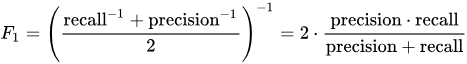

### <a name="summary">Summary</a>

[Back to content list](#content_list)

## 1. Preprocessing of text data

With help of some kernels I found out really nice information about data preprocessing for embeddings, which we can see in implementation.

I preprocessed data for most popular 3 embeddings which I saw in examples just for convinience in the second step.

## 2. Simple feed-forward neural network model

I used example from the lesson for simple feed-forward nn model and decreased dimensions with tensor.view().

I received low F1 score, ~0,11

Why f1 score?

I think that it is a good metric because it is the harmonic mean between precision(точність) and recall(повнота).

Don't realize, why accuracy so low, I preprocessed df for embeddings specific embeddings, 
I tried to:
- Create new layer 100, 10
- Increase epochs count to 20

It didn't help to increase F1 score and decrease the loss for NN model.

## 3. TF-IDF vectorizer and Logistic regression

For 3rd task I used tf-idf vectorizer + logistic regression. 

I have an experience with logistic regression and logistic regression works more clear for me than rnn.

F1 score > 0.6, I think that's good result, because a lot of kernels with rnn or logistic regression have f1 score ~0.6

But it can be better, we can try to:
- Change TfIdf vectorizer settings, espessially try to use another token pattern, analyzer, etc. 
- Change C parameter
- Change random state(seeds) parameter